# Tutorial - Skin Lesion Classification using Dermoscopic Images

In [1]:
%matplotlib inline
import matplotlib
matplotlib.use("TkAgg")


In [2]:
import sys
sys.path.append("../../")
import torch
from torchvision import transforms
import torch.nn as nn

import pandas as pd
from PIL import Image
import numpy as np
import math
import os
import argparse
import matplotlib.pyplot as plt

from aix360.algorithms.dipvae.dipvae_utils import VAE, DIPVAE
from aix360.algorithms.dipvae import DIPVAEExplainer
from train_tutorial_dermatology_models import *

In this tutorial, we focus on an important application in clinical medicine: dermoscopy. Physicians examine images of the skin acquired using a dermoscope, a special camera apparatus that minimizes skin surface reflections, to diagnose diseases such as skin cancer: the most commonly diagnosed cancer in the United States and other countries.

Recent advances in deep neural networks have yielded models that outperform expert dermatologists. However, there is still an interpretability gap in adopting these models in clinical practice [1].

Dermatologists use rules of thumb when initially investigating a skin lesion. The most common is known as the ABCD signs: asymmetry, border, color, and diameter. These signs are in fact a low-dimensional representation of the image in terms of meaningful high-level concepts. One potential way to build the trust of machine learning among dermatologists is to learn representations that capture the high-level concepts. These explainable data representations can then be used in further modeling. We demonstrate the use of the Disentangled Inferred Prior Variational Autoencoder (DIP-VAE) in an attempt to do just that.

Most real-world scenarios involve raw observations without any supervision about the generative factors or high-level concepts. For such data, we can rely on latent generative models such as variational autoencoder (VAE) [2] that aim to maximize the likelihood of generating new examples that match the observed data. 

For inferring disentangled factors, inferred prior or expected variational posterior should be factorizable along its dimensions. DIP-VAE [3] adopts a simple yet effective approach to match the moments of the two distributions. Matching the covariance of the two distributions will amount to decorrelating the dimensions of the inferred prior.

In this notebook, we demonstrate the use of DIP-VAE model for unsupervised learning of disentangled hidden factors from a large pool of unlabeled observations using the ISIC dataset [4] and show the utility of these representations in a downstream disease classification task.

[1] Codella, Noel CF, et al. "Collaborative Human-AI (CHAI): Evidence-based interpretable melanoma classification in dermoscopic images." Understanding and Interpreting Machine Learning in Medical Image Computing Applications. Springer, Cham, 2018. 97-105.

[2] Diederik P Kingma and Max Welling. Auto-encoding variational Bayes. ICLR, 2014.

[3] Kumar, A., Sattigeri, P., and Balakrishnan, A. Variational inference of disentangled latent concepts from unlabeled observations. ICLR, 2018.

[4] https://challenge2018.isic-archive.com/task3/

This dataset contains 10000 images in the training set with each image belonging to exactly to one of the classes below.

    Melanoma
    Melanocytic nevus
    Basal cell carcinoma
    Actinic keratosis / Bowen’s disease (intraepithelial carcinoma)
    Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis)
    Dermatofibroma
    Vascular lesion

In [119]:
Image(url='https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task3.png')

In [3]:
cuda_available = torch.cuda.is_available()
print("CUDA: {}".format(cuda_available))

CUDA: False


# Load the ISIC dataset

In [4]:
root_data_path = #<The path to folder containing the ISIC dataset.>
root_images_path = os.path.join(root_data_path, 'ISIC2018_Task3_Training_Input/')
file_path_labels = os.path.join(root_data_path, 'ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

In [5]:
dataset_obj = ISICDataset(root_images_path=root_images_path,
                          file_path_labels=file_path_labels,
                          batch_size=32)

# Load pretrained DIP-VAE models

In the next cell we will set the various options to train the DIP-VAE model. First of all, DIP-VAE Explainer model support the baseline VAE model and the two modes of DIP-VAE - i and ii (See [1] for the differences). 

Next, we will set the architecture parameters including activation_type, number of hidden nodes and the latent dimensions. The default implementations containing fully connected encoders and decoders. A user defined model can be specified as model_args.model = 'user-defined' and passed to the fit function.

The rest of the parameters include number of epochs to train and the hyperparameters for the DIP-VAE regularizer. 

In this case, we use a pretrained model that is trained using convolutional encoder and decoder. The training script can be found in the same folder with the name `train_tutorial_dermatology_models.py`.

Below we will load a model trained with the hyperparameters specified below that were also used in the training.

In [6]:
model_args = argparse.Namespace()

model_args.model = 'user-defined'
model_args.activation_type = 'relu'
model_args.num_filters = 32
model_args.latent_dim = 10
model_args.num_channels =  dataset_obj.data_dims[0]
model_args.image_size =  dataset_obj.data_dims[-1]
model_args.step_size = 0.0001
model_args.num_epochs = 20
model_args.lambda_diag_factor = 10.0
model_args.lambda_offdiag = 0.001
model_args.output_activation_type = dataset_obj.output_activation_type
model_args.likelihood_type = dataset_obj.likelihood_type
model_args.mode='ii'
model_args.beta=0.001
model_args.seed=0

model_args.fit=0
model_args.root_save_dir = #<The root folder where the pre-trained models are saved.>


In [7]:
# Parse the model args to generate the path to load the pre-trained model.
setup = [
        ('model={:s}', model_args.model),
        ('lambda_diag_factor={:.0e}', model_args.lambda_diag_factor),
        ('lambda_offdiag={:.0e}', model_args.lambda_offdiag),
        ('beta={:.0e}', model_args.beta),
    ]
save_dir = os.path.join(model_args.root_save_dir, "results"+'_'.join([t.format(v) for (t, v) in setup]))

In [8]:
net = torch.load(os.path.join(save_dir, 'net.p'),  map_location='cpu')

In [9]:
# Change to True if training on GPU.
net.cuda_available=False

# Lets initialize the DIPVAE Explainer with the pre-trained autoencoder.

The `DIPVAEExplainer` is initialized using the pretrained generative model and the dataset. We can use this explainer to introspect the learned generative model. The `explain` method takes in the image sand returns the modified images generated after altering the latent dimension in isolation. This can help associate a dimension to a meaningful generative factor. Ideally, a disentangled latent dimension produce small meaningful change in the image that corresponds to true data generating factors.

In [10]:
dipvaeii_explainer = DIPVAEExplainer(net=net, dataset=dataset_obj, cuda_available=cuda_available,
                                         model_args=model_args)

Let us visualize the reconstruction generated by the training model.

In [11]:
for x, _ in dataset_obj.next_batch():
    if dipvaeii_explainer.cuda_available:
        x = x.cuda()
    plot_reconstructions(dipvaeii_explainer.dataset, dipvaeii_explainer.net, x, image_id_to_plot=2,
                         epoch='end', batch_id = 'end', save_dir='.')
    plot_latent_traversal(dipvaeii_explainer, x, dipvaeii_explainer.model_args, dipvaeii_explainer.dataset,
                          image_id_to_plot=2, epoch='end', batch_id='end', save_dir='.')
    break

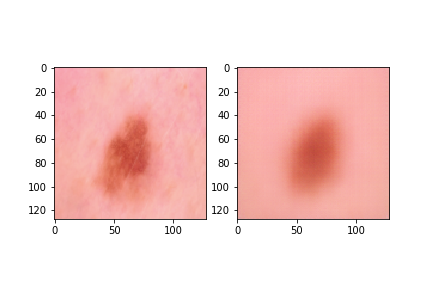

In [12]:
from IPython.display import Image
Image(filename='recons_epoch_end_batch_id_end.png') 

Below we show decoder's output for latent traversals (varying a single latent at a time while keeping others fixed). Ideally, each dimension should control a generative factor or be switched off. It appears that the zeroth and fifth dimension are capturing the notion of "diameter", the first, second and third dimensions are capturing "border", and the ninth dimension is capturing "asymmetry".

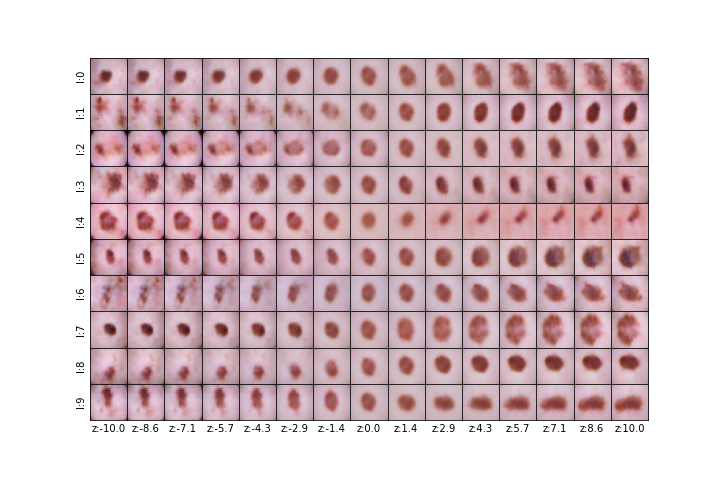

In [13]:
Image(filename='traversal_epoch_end_batch_id_end.png') 

# Visualize latent distribution across classes


Let us investigate if the latents contain discriminatory information and if certain latent dimensions are particularly active for certain classes. We first call the `encode` method to get the latent representations for all the images. 

Next, we will get the mean and standard deviation of the latents features for each class. These are visualized in the top row of the figure below.

We can take this average representation and pass it through the decoder to visualize the corresponding representative image for each class. When we use the model predictions to get class specific images, we can get a understanding of what the model considers as the representative image for each class.


In [24]:
# Get the latent representations
latents_list = []
labels_list = []
for x, y in dataset_obj.next_batch():
    if dipvaeii_explainer.cuda_available:
        x = x.cuda()
        y = y.cuda()
    latents_list.append(net.encode(x)[1].detach().cpu().numpy())
    labels_list.append(y.detach().cpu().numpy())

In [25]:
latent_features = np.concatenate(latents_list)

In [26]:
labels = np.concatenate(labels_list)

In [38]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [89]:
class_names = ["Melanoma", "Nevus", "Basal", "Bowen", "Pigmented", "Dermatofibroma", "Vascular"]

/anaconda2/envs/testpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


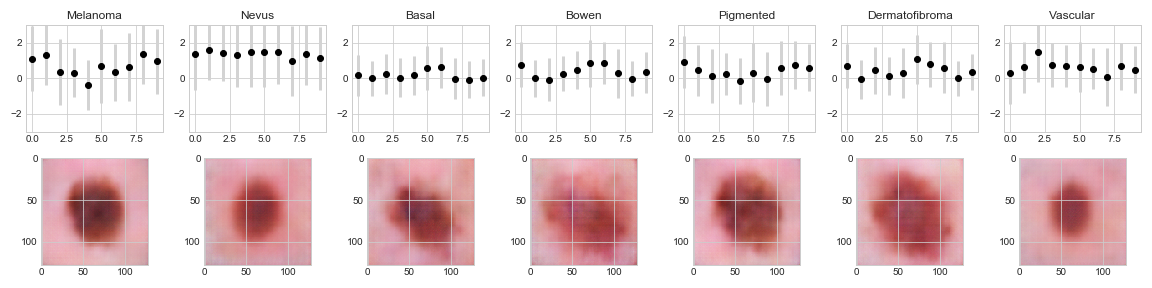

In [90]:
# Plot histogram of latent values for each class
fig, ax = plt.subplots(2, 7, figsize=(16, 4))
for idx in range(7):
    class_latent_features_mean, class_latent_features_std = np.mean(latent_features[labels==idx], axis=0), np.std(latent_features[labels==idx], axis=0)
    #print(class_latent_features)
    

    #ax[idx].plot(class_latent_features)
    ax[0][idx].errorbar(list(range(10)), class_latent_features_mean, yerr=class_latent_features_std, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    ax[0][idx].set_ylim([-3,3])
    ax[0][idx].set_title(class_names[idx])
    ax[1][idx].imshow(net.decode(torch.tensor(class_latent_features_mean.reshape(1,10))).detach().cpu().numpy().transpose(0,2,3,1)[0]*0.5 + 0.5)


plt.tight_layout()
plt.savefig('class_specific_histograms.png')
Image(filename='class_specific_histograms.png') 

In the box plots (top row) above, we can clearly see different patterns of the latents across classes. Looking at the first dimension (second black row in each figure in the top row) that appears to correspond to the `border` attribute, we can see that Melanoma and Nevus classes have high activation for this dimension and have strong sense of border. While, Basel and Bowen classes do not have strong sense of border and this latent is switched off on average. These are also reflected in the images generated from these average latent for each class (bottom row).

# Lets learn a simple model on the latent features to predict the disease classes.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.33, random_state=42)

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

#clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
#clf = LinearSVC(random_state=0, tol=1e-5).fit(X_train, y_train)
clf = RandomForestClassifier(n_estimators=500, max_depth=10,random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.702874432677761

We get an accuracy of ~70% using Random Forests on the internal validation set created from training set. For comparison the best accuracy on the ISIC 2018 leaderboard is ~88% that uses ensemble of deep neural networks on comparable validation set. 

# Plot the distribution of latent values for each class in test set

In [ ]:
fig, ax = plt.subplots(2, 7, figsize=(16, 4))
for idx in range(7):
    X_test_mean, X_test_std = np.mean(X_test[y_test==idx], axis=0), np.std(X_test[y_test==idx], axis=0)
    #print(class_latent_features)
    

    #ax[idx].plot(class_latent_features)
    ax[0][idx].errorbar(list(range(10)), X_test_mean, yerr=X_test_std, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    ax[0][idx].set_ylim([-3,3])
    ax[0][idx].set_title(class_names[idx])
    ax[1][idx].imshow(net.decode(torch.tensor(X_test_mean.reshape(1,10))).detach().cpu().numpy().transpose(0,2,3,1)[0]*0.5 + 0.5)


plt.tight_layout()
plt.savefig('class_specific_histograms_on_test_truth.png')
Image(filename='class_specific_histograms_on_test_truth.png') 

/anaconda2/envs/testpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/anaconda2/envs/testpy3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda2/envs/testpy3/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/anaconda2/envs/testpy3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/anaconda2/envs/testpy3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean

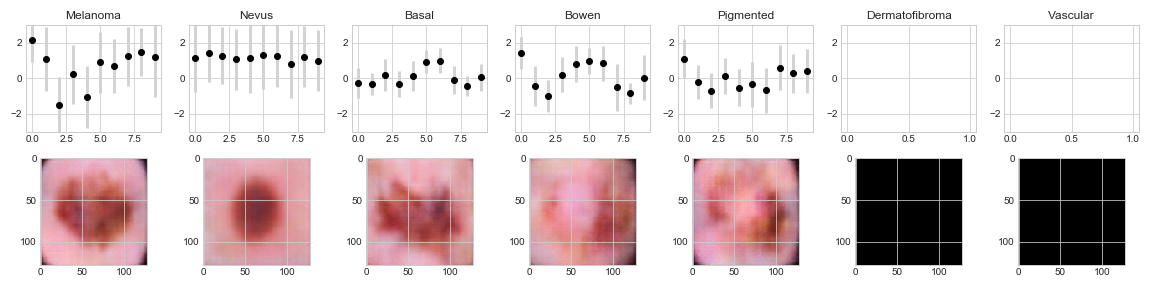

In [98]:
# Plot distribution of latent values for each class in test set based on model
fig, ax = plt.subplots(2, 7, figsize=(16, 4))
for idx in range(7):
    X_test_mean, X_test_std = np.mean(X_test[y_pred==idx], axis=0), np.std(X_test[y_pred==idx], axis=0)
    #print(class_latent_features)
    

    #ax[idx].plot(class_latent_features)
    ax[0][idx].errorbar(list(range(10)), X_test_mean, yerr=X_test_std, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    ax[0][idx].set_ylim([-3,3])
    ax[0][idx].set_title(class_names[idx])
    ax[1][idx].imshow(net.decode(torch.tensor(X_test_mean.reshape(1,10))).detach().cpu().numpy().transpose(0,2,3,1)[0]*0.5 + 0.5)


plt.tight_layout()
plt.savefig('class_specific_histograms_on_test_pred.png')
Image(filename='class_specific_histograms_on_test_pred.png') 

The RF model fails to detect any samples from the last two classes in the test set. By looking at the latent distribution we can visualize what features the model assigns higher importance for each class.

# Lets train a logistic regression classifier

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)
y_pred_scores = clf.predict_proba(X_test)

The performance is lower (~68) than RF but still much better than chance. This shows that the latents capture discriminatory information and is sufficiently disentangled to ease the learning of simpler classifier.

/anaconda2/envs/testpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


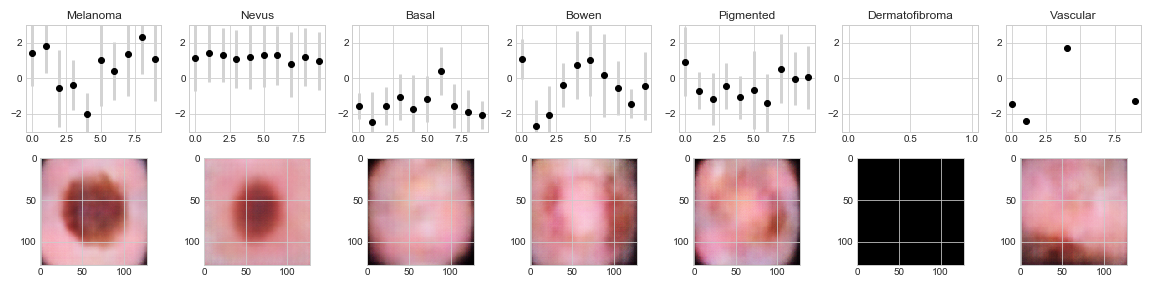

In [100]:
# Plot the distribution of latent values for each class in test set based on model
fig, ax = plt.subplots(2, 7, figsize=(16, 4))
for idx in range(7):
    X_test_mean, X_test_std = np.mean(X_test[y_pred==idx], axis=0), np.std(X_test[y_pred==idx], axis=0)
    #print(class_latent_features)
    

    #ax[idx].plot(class_latent_features)
    ax[0][idx].errorbar(list(range(10)), X_test_mean, yerr=X_test_std, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);
    ax[0][idx].set_ylim([-3,3])
    ax[0][idx].set_title(class_names[idx])
    ax[1][idx].imshow(net.decode(torch.tensor(X_test_mean.reshape(1,10))).detach().cpu().numpy().transpose(0,2,3,1)[0]*0.5 + 0.5)


plt.tight_layout()
plt.savefig('class_specific_histograms_on_test_pred_LR.png')
Image(filename='class_specific_histograms_on_test_pred_LR.png') 

# Lets look at the average image at different probability thresholds for Melanoma and Vascular classes.

Logistic regression classifier provides us probability scores for each class. We can further look the subset of images that the model predicted as a particular class with high confidence. By looking at the latent distribution among these high confidence we can get more intuition into what are the latent dimensions that are most active for each class.

/anaconda2/envs/testpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


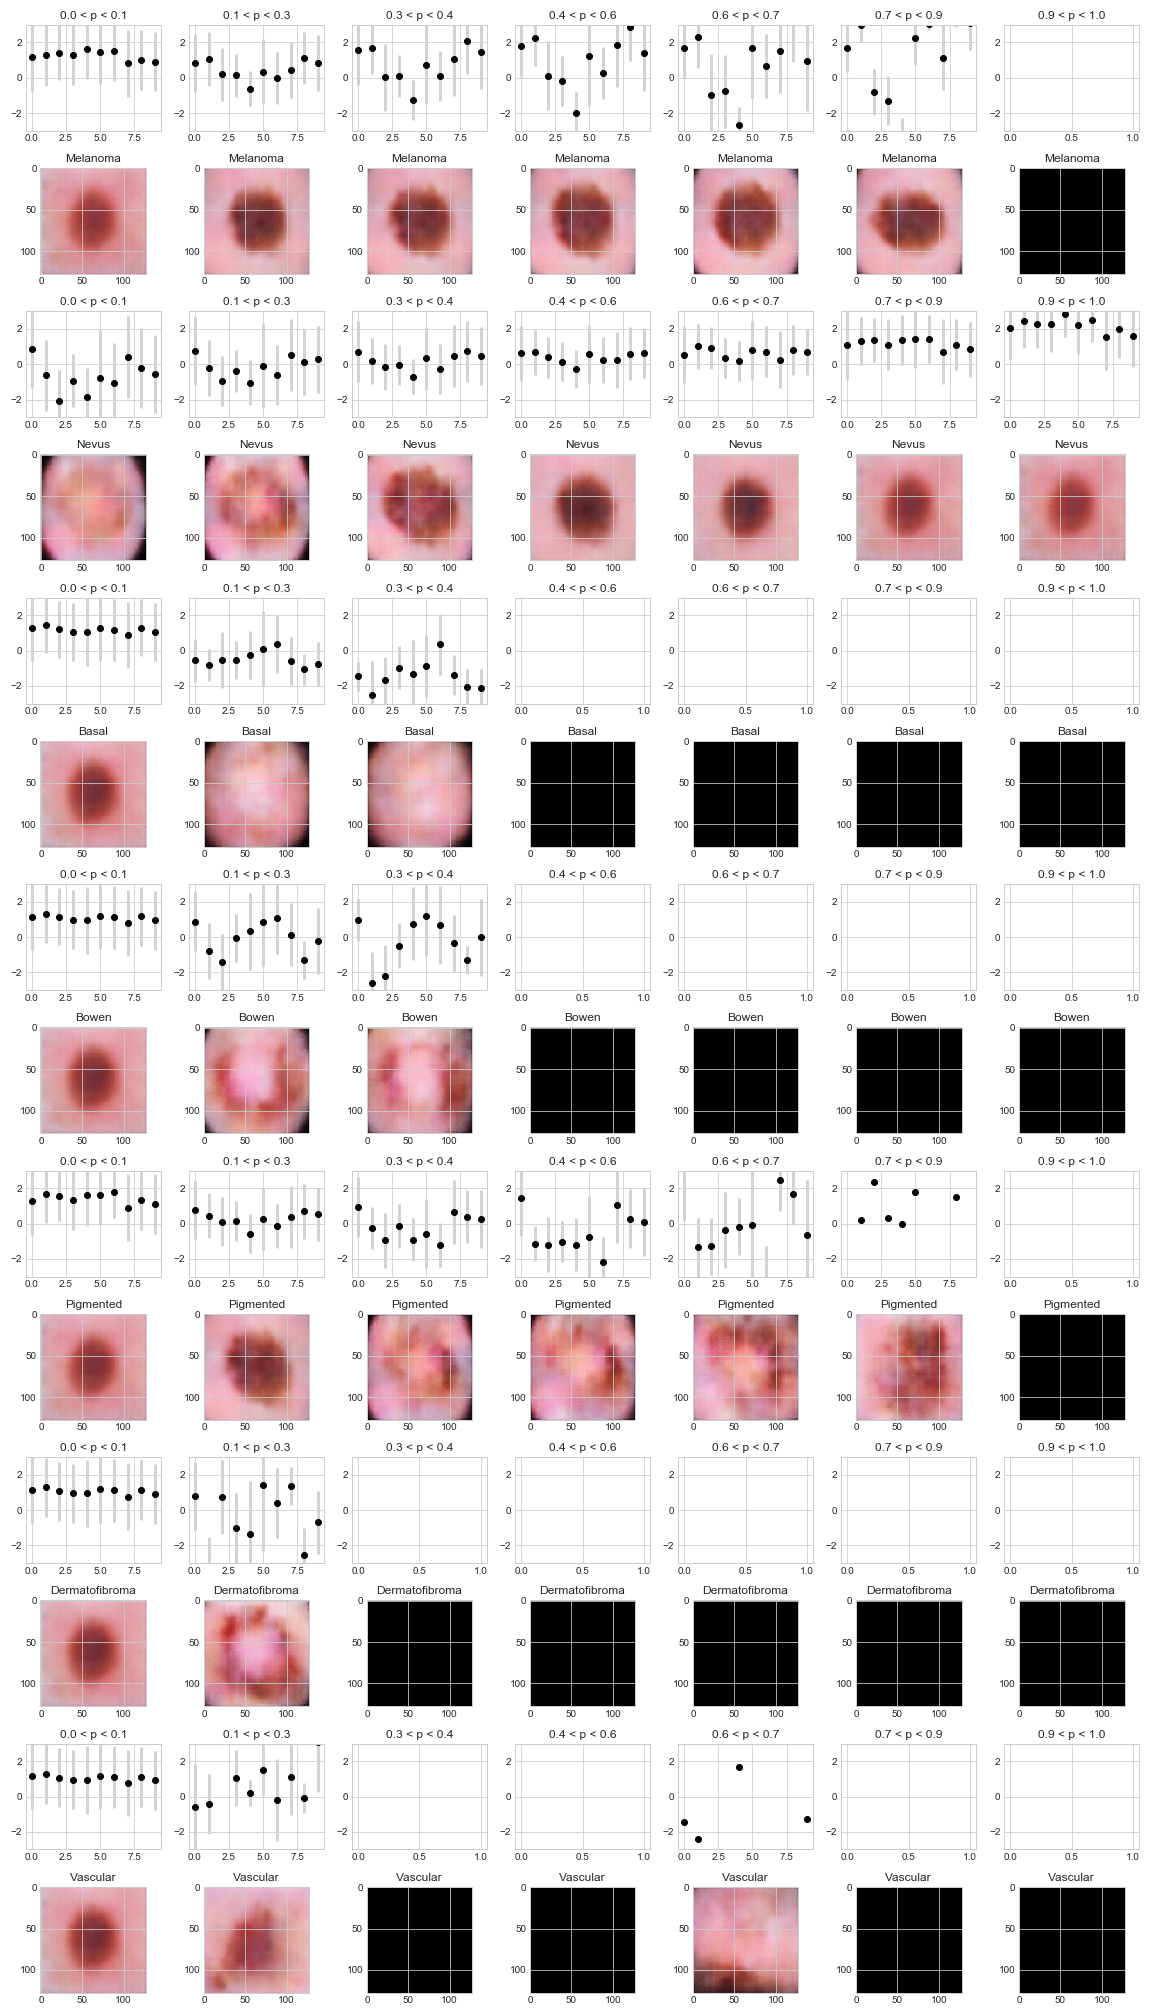

In [117]:
# Plot histogram of latent values for each class in test set based on model
fig, ax = plt.subplots(2*7, 7, figsize=(16, 4*7))
scores_thresholds = np.array(list(range(8)))/7.0
for disease_id in range(7):
    for idx in range(7):
        X_test_c = X_test[(y_pred_scores[:,disease_id] >= scores_thresholds[idx]) & (y_pred_scores[:,disease_id] <= scores_thresholds[idx+1])]
        X_test_mean, X_test_std = np.mean(X_test_c, axis=0), np.std(X_test_c, axis=0)
        #print(class_latent_features)


        #ax[idx].plot(class_latent_features)
        ax[0+disease_id*2][idx].errorbar(list(range(10)), X_test_mean, yerr=X_test_std, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3, capsize=0);
        ax[0+disease_id*2][idx].set_ylim([-3,3])
        ax[0+disease_id*2][idx].set_title(str(round(scores_thresholds[idx], 1))  + " < " +"p < " + str(round(scores_thresholds[idx+1], 1)))
        ax[1+disease_id*2][idx].imshow(net.decode(torch.tensor(X_test_mean.reshape(1,10))).detach().cpu().numpy().transpose(0,2,3,1)[0]*0.5 + 0.5)
        ax[1+disease_id*2][idx].set_title(class_names[disease_id])

plt.tight_layout()
plt.savefig('class_specific_histograms_on_test_pred_LR_probs.png')
Image(filename='class_specific_histograms_on_test_pred_LR_probs.png') 

From these plots, we can see that classes - Melanoma, Nevus and Pigmented are classified by the model with high confidence compared to other classes. In the case of Melanoma and Nevus, the border attribute becomes stronger with increasing confidence.

## Conclusions

In this tutorial, we investigated the representations learned by `DIPVAE`generative model on dermatology dataset. When the representations are explainable, they can lead to decisions that are potentially comprehensible by humans, improving interpretability. They are arguably better suited to transfer learning, as most of the key underlying generative factors appear segregated along feature dimensions and can be selectively shared across various tasks. We showed that a simple model can be used to train disease classifier on such representations. These representations will also enable controllable generation of new data through generative process. This can be used to get useful insights on the functioning of the downstream task specific models. Finally, machine learning systems built on explainable representations will be more amenable to inspection, helping to build trust in machine learning systems.